# `good_weather_is_correlated_with_predictable_results.ipynb`

### Author: Anthony Hein

#### Last updated: 11/8/2021

# Overview:

This notebook shows that good weather is correlated with predictable results.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="whitegrid")

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [5]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Load `horses_selected_trimmed_clean.csv`

In [6]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,RPR,TR,OR,father,mother,gfather,weight,res_win,res_place,res_show
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,102.0,NaN,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,94.0,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,92.0,NaN,NaN,Nordico,Over The Seas,North Summit,71,0,0,0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0


In [7]:
horses_clean.shape

(202304, 22)

---

## Calculate Good Weather Metric

In [8]:
races_featurized['scaled_temp'] = (races_featurized['temp'] - np.mean(races_featurized['temp'])) \
                                   / np.std(races_featurized['temp'])

In [9]:
races_featurized['scaled_msl'] = (races_featurized['msl'] - np.mean(races_featurized['msl'])) \
                                   / np.std(races_featurized['msl'])

In [10]:
races_featurized['scaled_rhum'] = (races_featurized['rhum'] - np.mean(races_featurized['rhum'])) \
                                   / np.std(races_featurized['rhum'])

In [11]:
races_featurized['scaled_rain'] = (races_featurized['rain'] - np.mean(races_featurized['rain'])) \
                                   / np.std(races_featurized['rain'])

In [12]:
races_featurized['weather_goodness'] = np.square(races_featurized['scaled_temp']) + \
                                       np.square(races_featurized['scaled_msl']) + \
                                       np.square(races_featurized['scaled_rhum']) + \
                                       np.square(races_featurized['scaled_rain'])

In [13]:
np.mean(races_featurized['temp'])

13.835102222662243

In [14]:
np.mean(races_featurized['msl'])

1013.3489480718777

In [15]:
np.mean(races_featurized['rhum'])

73.70026236324935

In [16]:
np.mean(races_featurized['rain'])

0.1157566457106084

In [18]:
races_featurized[['temp', 'msl', 'rhum', 'rain', 'weather_goodness']]

,temp,msl,rhum,rain,weather_goodness
0,1.6,1012.4,87,0.0,7.931984
1,8.0,992.5,87,0.4,6.713561
2,12.0,1003.5,73,0.0,1.077770
3,12.6,1011.9,72,0.0,0.158882
4,11.1,994.2,59,0.0,4.810328
...,...,...,...,...,...
20196,2.5,988.8,93,0.0,13.346305
20197,3.5,989.8,86,0.0,10.746444
20198,2.8,1008.2,84,0.0,6.492927
20199,4.1,1021.0,85,0.0,5.641260


In [34]:
def calculate_predictability_of_results(row: pd.core.frame.DataFrame):
    return (row['1st_place_rank_in_odds'] + row['2nd_place_rank_in_odds'] + row['3rd_place_rank_in_odds']) \
            / row['runners']

In [37]:
races_featurized['predictability'] = races_featurized.apply(calculate_predictability_of_results, axis=1)

In [40]:
races_featurized['weather_goodness'].corr(races_featurized['predictability'])

0.007790754170141152

In [41]:
races_featurized['weather_goodness'].corr(races_featurized['1st_place_rank_in_odds'])

0.005232732765421159

array([[<AxesSubplot:title={'center':'weather_goodness'}>]], dtype=object)

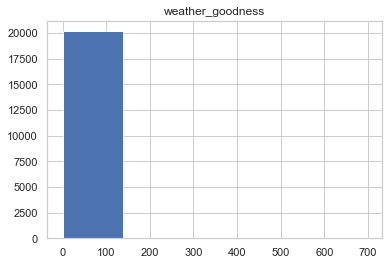

In [45]:
races_featurized.hist('weather_goodness', bins=5)